In [81]:
from datasets import load_dataset
from dotenv import load_dotenv
import os
from huggingface_hub import login
import pandas as pd
from generator_flow import generator
from generator_flow import normal_generator

Load examples

In [82]:
load_dotenv()
login(os.getenv("HF_API_KEY"))
dataset = load_dataset("Tamiza/zimpl_data")
df_manual = dataset['test'].to_pandas()
dataset

DatasetDict({
    test: Dataset({
        features: ['input', 'output', 'parameter', 'solution'],
        num_rows: 67
    })
})

Table for manual tests

In [83]:
df_manual


,input,output,parameter,solution
0,A bakery produces two types of cookies: chocol...,"set CookieTypes := {""Caramel"", ""ChocolateChip""...",1,objective value: ...
1,"""The factory produces two products, W1 and W2,...","set Products := {""W1"", ""W2""};\nset Resources :...",1,objective value: ...
2,A mining company produces lignite and anthraci...,"set CoalTypes := {""Lignite"", ""Anthracite""};\ns...",1,objective value: ...
3,"A company has two warehouses, Warehouse A and ...","set Warehouses := {""A"", ""B""};\nset Stores := {...",1,objective value: ...
4,A nutritionist wants to create a diet plan for...,"set Foods := {""Food1"", ""Food2"", ""Food3""};\nset...",1,objective value: ...
...,...,...,...,...
62,A health-conscious family wants to have a very...,var x; # number of banana servings taken\nvar ...,0,objective value: 11.363636...
63,A campsite for caravans and tents has an area ...,var x integer; # number of caravans\nvar y ...,0,objective value: ...
64,A factory manufactures doodads and whirligigs....,var x integer; # Each doodad costs $2 to make ...,0,objective value: ...
65,The annual subscription for a tennis club is £...,var x integer; # number of adult members\nv...,0,objective value: ...


Generate responses using AI ZIMPL Generator (for now first 10)

In [84]:
df_manual['ai_advanced'] = df_manual.apply(lambda row: generator(row['input'], row['parameter']), axis=1)

Show answers

In [85]:
df_manual[:5].map(lambda x: str(x)).style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})

,input,output,parameter,solution,ai_advanced
0,"A bakery produces two types of cookies: chocolate chip and caramel. The bakery anticipates daily demand for a minimum of 80 caramelized & 120 chocolate chip cookies. Due to a lack of raw materials and labor, the bakery can produce 120 caramel cookies and 140 chocolate chip cookies daily. For the bakery to be viable, it must sell a minimum of 240 cookies each day. Every chocolate chip cookie served generates $0.75 in profit, whereas each caramel biscuit generates $0.88. The solution to the number of chocolate chip and caramel cookies that the bakery must produce each day to maximize profit may be determined using linear programming.","set CookieTypes := {""Caramel"", ""ChocolateChip""}; # Parameters for daily demand and production limits param min_demand[CookieTypes] := <""Caramel""> 80, <""ChocolateChip""> 120; param max_production[CookieTypes] := <""Caramel""> 120, <""ChocolateChip""> 140; # Parameter for minimum total sales param min_total_sales := 240; # Parameters for profit per cookie (in dollars) param profit[CookieTypes] := <""Caramel""> 0.88, <""ChocolateChip""> 0.75; # Decision variables: quantity of each cookie type produced daily var x[ in CookieTypes] >= min_demand[c]; # Objective function: Maximize total profit maximize total_profit: sum in CookieTypes: profit[c] * x[c]; # Constraints: Ensure minimum total cookies are sold subto total_sales: sum in CookieTypes: x[c] >= min_total_sales; # Constraints: Do not exceed daily production limits subto production_limits: forall in CookieTypes do x[c] <= max_production[c];",1,objective value: 210.6 x$Caramel 120 (obj:0.88) x$ChocolateChip 140 (obj:0.75),"set CookieTypes := {""Caramel"", ""ChocolateChip""}; set Demand := {""CaramelDemand"", ""ChocolateChipDemand""}; set ProductionLimits := {""CaramelLimit"", ""ChocolateChipLimit""}; param demand[Demand] := <""CaramelDemand""> 80, <""ChocolateChipDemand""> 120; param production_limit[ProductionLimits] := <""CaramelLimit""> 120, <""ChocolateChipLimit""> 140; param min_total_sales := 240; param profit[CookieTypes] := <""Caramel""> 0.88, <""ChocolateChip""> 0.75; # Decision variables var x[ in CookieTypes] integer >= 0 <= production_limit[""Limit""]; # Quantity of each cookie type produced daily var y[ in Demand] integer >= demand[d]; # Quantity of cookies to meet daily demand # Objective function maximize total_profit: sum in CookieTypes: profit[c] * x[c]; # Constraints # Minimum demand constraints subto min_demand_constraints: forall in Demand do if d == ""CaramelDemand"" then y[d] >= demand[d] else # Here d must be ""ChocolateChipDemand"" y[d] >= demand[d] end; # Total cookies sold must meet minimum requirement subto total_sales: sum in Demand: y[d] >= min_total_sales; # Production limits subto production_limits: forall in ProductionLimits do if (p == ""CaramelLimit"") then x[""Caramel""] <= production_limit[p] else # Here p must be ""ChocolateChipLimit"" x[""ChocolateChip""] <= production_limit[p] end; [end example]"
1,"""The factory produces two products, W1 and W2, using resources S1, S2, and S3. To produce W1, the factory uses 2 units of S1, 1 unit of S2, and 4 units of S3. To produce W2, the factory uses 2 units of S1 and 2 units of S2. The weekly limit for resources is 14, 8, and 16 units, respectively. The selling prices of the products are $2 and $3, respectively. Determine the production plan that would maximize the profit from sales.""","set Products := {""W1"", ""W2""}; set Resources := {""S1"", ""S2"", ""S3""}; # Parameters for resource usage per product param resource_usage[Products * Resources] := | ""S1"", ""S2"", ""S3"" | |""W1"" | 2, 1, 4 | |""W2"" | 2, 2, 0 |; # Weekly resource limits param resource_limits[Resources] := <""S1""> 14, <""S2""> 8, <""S3""> 16; # Selling price per unit of each product param selling_price[Products] := <""W1""> 2, <""W2""> 3; # Decision variables: weekly production quantity of each product var x[ in Products] >= 0; # Objective functi

In [86]:
df_manual['ai_normal'] = df_manual['input'].apply(normal_generator)

In [87]:
from pandas import DataFrame
df_manual[:5][['output', 'ai_advanced', 'ai_normal']].map(lambda x: str(x)).style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})

,output,ai_advanced,ai_normal
0,"set CookieTypes := {""Caramel"", ""ChocolateChip""}; # Parameters for daily demand and production limits param min_demand[CookieTypes] := <""Caramel""> 80, <""ChocolateChip""> 120; param max_production[CookieTypes] := <""Caramel""> 120, <""ChocolateChip""> 140; # Parameter for minimum total sales param min_total_sales := 240; # Parameters for profit per cookie (in dollars) param profit[CookieTypes] := <""Caramel""> 0.88, <""ChocolateChip""> 0.75; # Decision variables: quantity of each cookie type produced daily var x[ in CookieTypes] >= min_demand[c]; # Objective function: Maximize total profit maximize total_profit: sum in CookieTypes: profit[c] * x[c]; # Constraints: Ensure minimum total cookies are sold subto total_sales: sum in CookieTypes: x[c] >= min_total_sales; # Constraints: Do not exceed daily production limits subto production_limits: forall in CookieTypes do x[c] <= max_production[c];","set CookieTypes := {""Caramel"", ""ChocolateChip""}; set Demand := {""CaramelDemand"", ""ChocolateChipDemand""}; set ProductionLimits := {""CaramelLimit"", ""ChocolateChipLimit""}; param demand[Demand] := <""CaramelDemand""> 80, <""ChocolateChipDemand""> 120; param production_limit[ProductionLimits] := <""CaramelLimit""> 120, <""ChocolateChipLimit""> 140; param min_total_sales := 240; param profit[CookieTypes] := <""Caramel""> 0.88, <""ChocolateChip""> 0.75; # Decision variables var x[ in CookieTypes] integer >= 0 <= production_limit[""Limit""]; # Quantity of each cookie type produced daily var y[ in Demand] integer >= demand[d]; # Quantity of cookies to meet daily demand # Objective function maximize total_profit: sum in CookieTypes: profit[c] * x[c]; # Constraints # Minimum demand constraints subto min_demand_constraints: forall in Demand do if d == ""CaramelDemand"" then y[d] >= demand[d] else # Here d must be ""ChocolateChipDemand"" y[d] >= demand[d] end; # Total cookies sold must meet minimum requirement subto total_sales: sum in Demand: y[d] >= min_total_sales; # Production limits subto production_limits: forall in ProductionLimits do if (p == ""CaramelLimit"") then x[""Caramel""] <= production_limit[p] else # Here p must be ""ChocolateChipLimit"" x[""ChocolateChip""] <= production_limit[p] end; [end example]","var c: >= 0; # number of chocolate chip cookies produced var k: >= 0; # number of caramel cookies produced # Objective: Maximize profit maximize profit: 0.75 * c + 0.88 * k; # Constraints s.t. demand_chocolate: c >= 120; # minimum demand for chocolate chip cookies s.t. demand_caramel: k >= 80; # minimum demand for caramel cookies s.t. production_chocolate: c <= 140; # maximum production for chocolate chip cookies s.t. production_caramel: k <= 120; # maximum production for caramel cookies s.t. total_cookies: c + k >= 240; # minimum total cookies produced # Solve the model solve; # Output the results display c, k, profit;"
1,"set Products := {""W1"", ""W2""}; set Resources := {""S1"", ""S2"", ""S3""}; # Parameters for resource usage per product param resource_usage[Products * Resources] := | ""S1"", ""S2"", ""S3"" | |""W1"" | 2, 1, 4 | |""W2"" | 2, 2, 0 |; # Weekly resource limits param resource_limits[Resources] := <""S1""> 14, <""S2""> 8, <""S3""> 16; # Selling price per unit of each product param selling_price[Products] := <""W1""> 2, <""W2""> 3; # Decision variables: weekly production quantity of each product var x[ in Products] >= 0; # Objective function: Maximize total profit maximize total_profit: sum in Products: selling_price[p] * x[p]; # Constraints: Ensure resource usage does not exceed weekly limits subto resource_constraints: forall in Resources do sum in Products: resource_usage[p, r] * x[p] <= resource_limits[r];","set Products := {""W1"", ""W2""}; set Resources := {""S1"", ""S2"", ""S3""}; param prices[Products] := <""W1""> 2, <""W2""> 3; param resource_limit[Resources] := <""S1""> 14, <""S2""> 8, <""S3""> 16; param requirement[Products * Resources] := | ""S1"", ""S2"", ""S

## Solver results

In [88]:
from solver import run_scip_and_extract_solution
SCIP_PATH = r"C:\\Program Files\\SCIPOptSuite 9.1.0\\bin"

df_manual["ai_advanced"] = df_manual["ai_advanced"].astype(str)
df_manual["ai_normal"] = df_manual["ai_normal"].astype(str)

def process_zimpl_code(zimpl_code):
    try:
        valid, result = run_scip_and_extract_solution(zimpl_code, SCIP_PATH)
        #print(f"Valid: {valid}, Result: {result}")
        return valid, result
    except Exception as e:
        #print(f"Error processing code: {e}")
        return False, None



df_manual[["valid_advanced", "result_advanced"]] = df_manual["ai_advanced"].apply(
    lambda code: pd.Series(process_zimpl_code(code))
)

df_manual[["valid_normal", "result_normal"]] = df_manual["ai_normal"].apply(
    lambda code: pd.Series(process_zimpl_code(code))
)

## Compare validation

In [89]:
import pandas as pd

print("ZIMPL generator results")
comparison_table = pd.DataFrame({
    "Category": [
        "Valid (True)",
        "Not Valid (False)",
    ],
    "Count": [
        (df_manual["valid_advanced"] == True).sum(),
        (df_manual["valid_advanced"] == False).sum(),
    ]
})

comparison_table["Percentage"] = (
    comparison_table["Count"] / len(df_manual) * 100
).round(2)

print(comparison_table)

print("ZIMPL generator results - hardcoded")
comparison_table = pd.DataFrame({
    "Category": [
        "Valid hardcoded (True)",
        "Not Valid hardcoded (False)",
    ],
    "Count": [
        ((df_manual["valid_advanced"] == True) & (df_manual["parameter"] == 0)).sum(),
        ((df_manual["valid_advanced"] == False) & (df_manual["parameter"] == 0)).sum(),
    ]
})

comparison_table["Percentage"] = (
    comparison_table["Count"] / comparison_table["Count"].sum() * 100
).round(2)

print(comparison_table)

print("ZIMPL generator results - params")
comparison_table = pd.DataFrame({
    "Category": [
        "Valid with params (True)",
        "Not Valid with params (False)"
    ],
    "Count": [
        ((df_manual["valid_advanced"] == True) & (df_manual["parameter"] == 1)).sum(),
        ((df_manual["valid_advanced"] == False) & (df_manual["parameter"] == 1)).sum(),
    ]
})

comparison_table["Percentage"] = (
    comparison_table["Count"] / comparison_table["Count"].sum() * 100
).round(2)

print(comparison_table)

print("Normal OpenAI model results")
comparison_table_normal = pd.DataFrame({
    "Category": [
        "Valid (True)",
        "Not Valid (False)",
    ],
    "Count": [
        (df_manual["valid_normal"] == True).sum(),
        (df_manual["valid_normal"] == False).sum(),
    ]
})

comparison_table_normal["Percentage"] = (
    comparison_table_normal["Count"] / len(df_manual) * 100
).round(2)

print(comparison_table_normal)

print("All results")
comparison_table = pd.DataFrame({
    "Category": [
        "Both Valid (True, True)",
        "Advanced Valid Only (True, False)",
        "Normal Valid Only (False, True)",
        "Both Invalid (False, False)",
    ],
    "Count": [
        ((df_manual["valid_advanced"] == True) & (df_manual["valid_normal"] == True)).sum(),
        ((df_manual["valid_advanced"] == True) & (df_manual["valid_normal"] == False)).sum(),
        ((df_manual["valid_advanced"] == False) & (df_manual["valid_normal"] == True)).sum(),
        ((df_manual["valid_advanced"] == False) & (df_manual["valid_normal"] == False)).sum(),
    ]
})

comparison_table["Percentage"] = (
    comparison_table["Count"] / len(df_manual) * 100
).round(2)

print(comparison_table)


ZIMPL generator results
            Category  Count  Percentage
0       Valid (True)     54        80.6
1  Not Valid (False)     13        19.4
ZIMPL generator results - hardcoded
                      Category  Count  Percentage
0       Valid hardcoded (True)     27       79.41
1  Not Valid hardcoded (False)      7       20.59
ZIMPL generator results - params
                        Category  Count  Percentage
0       Valid with params (True)     27       81.82
1  Not Valid with params (False)      6       18.18
Normal OpenAI model results
            Category  Count  Percentage
0       Valid (True)      0         0.0
1  Not Valid (False)     67       100.0
All results
                            Category  Count  Percentage
0            Both Valid (True, True)      0         0.0
1  Advanced Valid Only (True, False)     54        80.6
2    Normal Valid Only (False, True)      0         0.0
3        Both Invalid (False, False)     13        19.4


In [90]:
import pandas as pd

notvalid_rows_advanced = df_manual[df_manual['valid_advanced'] == False]
selected_columns = notvalid_rows_advanced[['output', 'ai_advanced', 'ai_normal']]
selected_columns.to_excel('not_valid.xlsx', index=False, engine='openpyxl')

print("Dane zostały zapisane w formacie XLSX do pliku not_valid.xlsx.")


Dane zostały zapisane w formacie XLSX do pliku not_valid.xlsx.


In [91]:
from IPython.display import display, HTML

df_manual["ai_advanced_display"] = df_manual["ai_advanced"].str.replace('\n', '<br>', regex=False)

html_content = df_manual["ai_advanced_display"].apply(lambda x: f'<div>{x}</div>').to_list()
#display(HTML(''.join(html_content)))

Check valid rows and search for correct results in advanced ZIMPL creator

In [92]:
from obj_fun_validator import compare_solutions

valid_rows_advanced = df_manual[df_manual['valid_advanced'] == True]
notvalid_rows_advanced = df_manual[df_manual['valid_advanced'] == False]
#print(valid_rows_advanced["result_advanced"])
#print(notvalid_rows_advanced["result_advanced"])

df_manual.loc[valid_rows_advanced.index, 'compare_advanced'] = valid_rows_advanced.apply(
    lambda row: compare_solutions(row['solution'], row['result_advanced'])[0], axis=1
)

valid_count = len(valid_rows_advanced)

#print(f"valid_advanced == True: {valid_count}")
#print(df_manual['compare_advanced'])

total_count = len(df_manual)
nan_count = df_manual['compare_advanced'].isna().sum()
true_count = (df_manual['compare_advanced'] == True).sum()
false_count = (df_manual['compare_advanced'] == False).sum()

nan_percentage = (nan_count / total_count) * 100
true_percentage = (true_count / total_count) * 100
false_percentage = (false_count / total_count) * 100

print(f"All stats:")
print(f"True: {true_count} ({true_percentage:.2f}%)")
print(f"False: {false_count} ({false_percentage:.2f}%)")
print(f"NaN: {nan_count} ({nan_percentage:.2f}%)")

non_nan_rows = df_manual.loc[~df_manual['compare_advanced'].isna()]
true_non_nan_count = (non_nan_rows['compare_advanced'] == True).sum()
false_non_nan_count = (non_nan_rows['compare_advanced'] == False).sum()

true_non_nan_percentage = (true_non_nan_count / valid_count) * 100
false_non_nan_percentage = (false_non_nan_count / valid_count) * 100

print(f"\nStats without NaN (valid_count = {valid_count}):")
print(f"True: {true_non_nan_count} ({true_non_nan_percentage:.2f}%)")
print(f"False: {false_non_nan_count} ({false_non_nan_percentage:.2f}%)")

#notvalid_rows_advanced["ai_advanced"].head(10)


All stats:
True: 46 (68.66%)
False: 8 (11.94%)
NaN: 13 (19.40%)

Stats without NaN (valid_count = 54):
True: 46 (85.19%)
False: 8 (14.81%)


Check valid rows and search for correct results in normal GPT model

In [93]:
valid_rows_normal = df_manual[df_manual['valid_normal'] == True]
#print(valid_rows["result_normal"])

df_manual.loc[valid_rows_normal.index, 'compare_normal'] = valid_rows_normal.apply(
    lambda row: compare_solutions(row['solution'], row['result_normal'])[0], axis=1
)

valid_count = len(valid_rows_normal)

#print(f"valid_normal == True: {valid_count}")
#print(df_manual['compare_normal'])

total_count = len(df_manual)
nan_count = df_manual['compare_normal'].isna().sum()
true_count = (df_manual['compare_normal'] == True).sum()
false_count = (df_manual['compare_normal'] == False).sum()

nan_percentage = (nan_count / total_count) * 100
true_percentage = (true_count / total_count) * 100
false_percentage = (false_count / total_count) * 100

print(f"All stats:")
print(f"NaN: {nan_count} ({nan_percentage:.2f}%)")
print(f"True: {true_count} ({true_percentage:.2f}%)")
print(f"False: {false_count} ({false_percentage:.2f}%)")

non_nan_rows = df_manual.loc[~df_manual['compare_normal'].isna()]
true_non_nan_count = (non_nan_rows['compare_normal'] == True).sum()
false_non_nan_count = (non_nan_rows['compare_normal'] == False).sum()

if valid_count == 0:
    true_non_nan_percentage = (true_non_nan_count / valid_count) * 100
    false_non_nan_percentage = (false_non_nan_count / valid_count) * 100
else:
    true_non_nan_percentage = 0
    false_non_nan_percentage = 0

print(f"\nStats without NaN (valid_count = {valid_count}):")
print(f"True: {true_non_nan_count} ({true_non_nan_percentage:.2f}%)")
print(f"False: {false_non_nan_count} ({false_non_nan_percentage:.2f}%)")

All stats:
NaN: 67 (100.00%)
True: 0 (0.00%)
False: 0 (0.00%)

Stats without NaN (valid_count = 0):
True: 0 (nan%)
False: 0 (nan%)


C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\2408835528.py:32: RuntimeWarning: invalid value encountered in scalar divide
  true_non_nan_percentage = (true_non_nan_count / valid_count) * 100
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\2408835528.py:33: RuntimeWarning: invalid value encountered in scalar divide
  false_non_nan_percentage = (false_non_nan_count / valid_count) * 100


### Validate results of advanced prompting with LLM

In [94]:
from generator_flow import validate_generator

df_manual['llm_score_advanced'] = df_manual.apply(
    lambda row: validate_generator(row['output'], row['ai_advanced'], row['parameter']),
    axis=1
)

print(df_manual[['output', 'ai_advanced', 'llm_score_advanced']].head(2))

                                              output  \
0  set CookieTypes := {"Caramel", "ChocolateChip"...   
1  set Products := {"W1", "W2"};\nset Resources :...   

                                         ai_advanced  \
0  set CookieTypes := {"Caramel", "ChocolateChip"...   
1  set Products := {"W1", "W2"};\nset Resources :...   

                                  llm_score_advanced  
0  Final Grade: 3  \nSets: 1  \nParameters: 1  \n...  
1  Final Grade: 5  \nSets: 1  \nParameters: 1  \n...  


### Validate results of normal prompting with LLM

In [95]:
from generator_flow import validate_generator

df_manual['llm_score_normal'] = df_manual.apply(
    lambda row: validate_generator(row['output'], row['ai_normal'], row['parameter']),
    axis=1
)

print(df_manual[['output', 'ai_normal', 'llm_score_normal']].head(2))

                                              output  \
0  set CookieTypes := {"Caramel", "ChocolateChip"...   
1  set Products := {"W1", "W2"};\nset Resources :...   

                                           ai_normal  \
0  var c: >= 0;  # number of chocolate chip cooki...   
1  var W1, W2;  # production quantities of produc...   

                                    llm_score_normal  
0  Final Grade: 3  \nSets: 0  \nParameters: 1  \n...  
1  ### Grading Evaluation\n\n1. **Definition of S...  


Create list of scores from generated results

In [96]:
import re

def convert_response_to_list(response):
    pattern = r"(\d+/\d+|\d+)"
    matches = re.findall(pattern, response)
    result = []
    for match in matches:
        if '/' in match:
            result.append(int(match.split('/')[0]))
        else:
            result.append(int(match))
    
    return result

In [110]:
import matplotlib.pyplot as plt

def get_final_grade(score_list):
    return score_list[0] if len(score_list) > 0 else None

def validate_final_grade(df, score=0, title="hardcoded"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    filtered_df_advanced = df[df['parameter'] == score]
    filtered_df_advanced['parsed_scores'] = filtered_df_advanced['llm_score_advanced'].apply(convert_response_to_list)
    final_grades_advanced = filtered_df_advanced['parsed_scores'].apply(get_final_grade)
    average_final_grade_advanced = final_grades_advanced.mean()
    grade_distribution_advanced = final_grades_advanced.value_counts().sort_index()

    ax1.bar(grade_distribution_advanced.index, grade_distribution_advanced.values, color='skyblue')
    ax1.set_title(f'Final Grade for {title} (advanced)')
    ax1.set_xlabel('Final Grade')
    ax1.set_ylabel('Count')
    ax1.set_xticks(grade_distribution_advanced.index)

    filtered_df_normal = df[df['parameter'] == score]
    filtered_df_normal['parsed_scores'] = filtered_df_normal['llm_score_normal'].apply(convert_response_to_list)
    final_grades_normal = filtered_df_normal['parsed_scores'].apply(get_final_grade)
    average_final_grade_normal = final_grades_normal.mean()
    grade_distribution_normal = final_grades_normal.value_counts().sort_index()

    ax2.bar(grade_distribution_normal.index, grade_distribution_normal.values, color='lightgreen')
    ax2.set_title(f'Final Grade for {title} (normal)')
    ax2.set_xlabel('Final Grade')
    ax2.set_ylabel('Count')
    ax2.set_xticks(grade_distribution_normal.index)

    plt.tight_layout()
    plt.show()

    print(f"Advanced Average Final Grade:", average_final_grade_advanced)
    print(f"Advanced Grade Distribution:")
    print(grade_distribution_advanced)

    print(f"\nNormal Average Final Grade:", average_final_grade_normal)
    print(f"Normal Grade Distribution:")
    print(grade_distribution_normal)

C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\4054348789.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_advanced['parsed_scores'] = filtered_df_advanced['llm_score_advanced'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\4054348789.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_normal['parsed_scores'] = filtered_df_normal['llm_score_normal'].apply(convert_response_to_list)


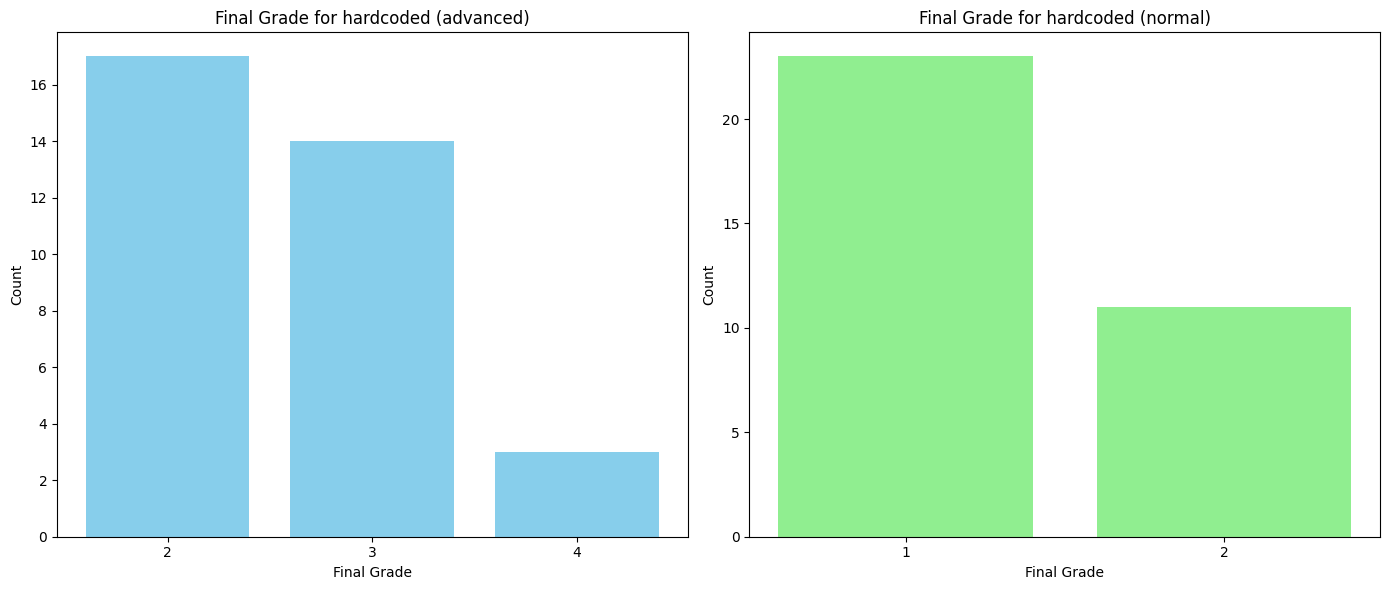

Advanced Average Final Grade: 2.588235294117647
Advanced Grade Distribution:
parsed_scores
2    17
3    14
4     3
Name: count, dtype: int64

Normal Average Final Grade: 1.3235294117647058
Normal Grade Distribution:
parsed_scores
1    23
2    11
Name: count, dtype: int64


In [111]:
validate_final_grade(df_manual, score = 0, title = "hardcoded")

C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\4054348789.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_advanced['parsed_scores'] = filtered_df_advanced['llm_score_advanced'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\4054348789.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_normal['parsed_scores'] = filtered_df_normal['llm_score_normal'].apply(convert_response_to_list)


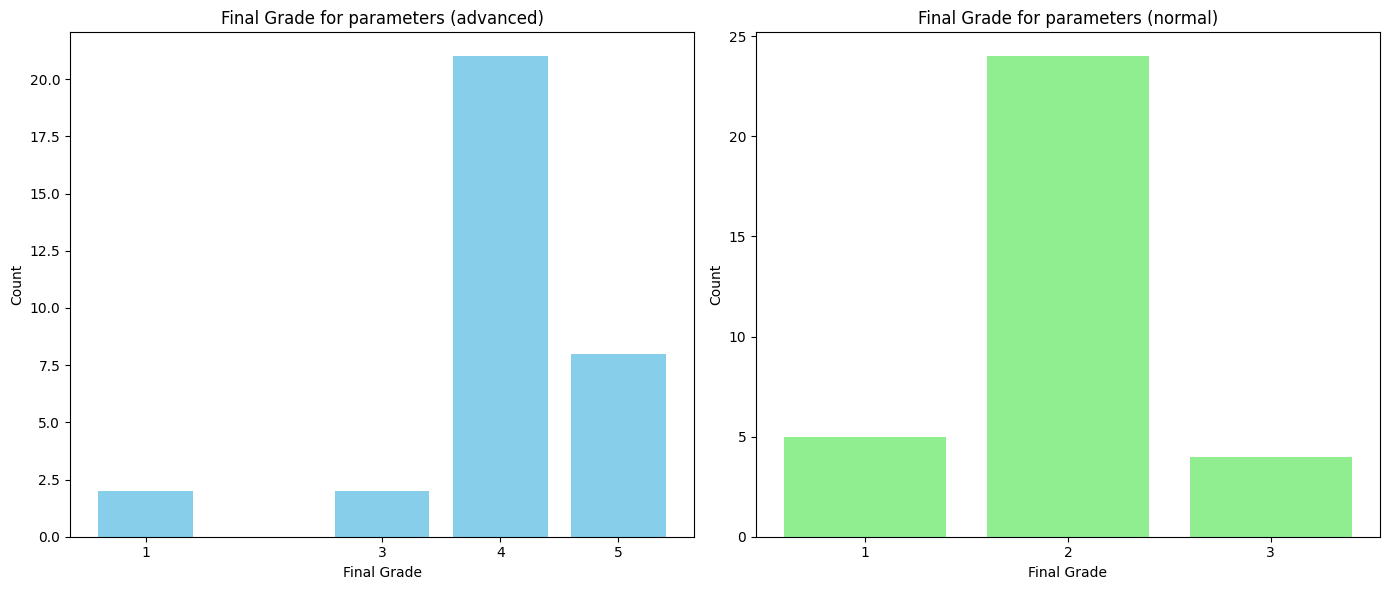

Advanced Average Final Grade: 4.0
Advanced Grade Distribution:
parsed_scores
1     2
3     2
4    21
5     8
Name: count, dtype: int64

Normal Average Final Grade: 1.9696969696969697
Normal Grade Distribution:
parsed_scores
1     5
2    24
3     4
Name: count, dtype: int64


In [99]:
validate_final_grade(df_manual, score = 1, title = "parameters")

In [119]:
def get_final_grade(score_list, category_index):
    if len(score_list) > category_index:
        return score_list[category_index]
    else:
        return None

def validate_final_grade(df, score=0, title="hardcoded"):
    categories_param_1 = ['Sets', 'Parameters', 'Decision Variables', 'Objective Function', 'Constraints', 'Miscellaneous']
    categories_param_0 = ['Variables', 'Objective Function', 'Constraints', 'Miscellaneous']
    
    categories = categories_param_1 if score == 1 else categories_param_0

    fig, axes = plt.subplots(len(categories), 2, figsize=(14, len(categories) * 6))

    for idx, category in enumerate(categories):
        filtered_df_advanced = df[df['parameter'] == score]
        filtered_df_advanced['parsed_scores'] = filtered_df_advanced['llm_score_advanced'].apply(convert_response_to_list)
        final_grades_advanced = filtered_df_advanced['parsed_scores'].apply(lambda x: get_final_grade(x, idx+1))
        grade_distribution_advanced = final_grades_advanced.value_counts().sort_index()

        filtered_df_normal = df[df['parameter'] == score]
        filtered_df_normal['parsed_scores'] = filtered_df_normal['llm_score_normal'].apply(convert_response_to_list)
        final_grades_normal = filtered_df_normal['parsed_scores'].apply(lambda x: get_final_grade(x, idx+1))
        grade_distribution_normal = final_grades_normal.value_counts().sort_index()

        ax = axes[idx, 0]
        ax.bar(grade_distribution_advanced.index, grade_distribution_advanced.values, color='skyblue')
        ax.set_title(f'{category} (advanced)')
        ax.set_xlabel('Grade')
        ax.set_ylabel('Count')
        ax.set_xticks(grade_distribution_advanced.index)

        ax = axes[idx, 1]
        ax.bar(grade_distribution_normal.index, grade_distribution_normal.values, color='lightgreen')
        ax.set_title(f'{category} (normal)')
        ax.set_xlabel('Grade')
        ax.set_ylabel('Count')
        ax.set_xticks(grade_distribution_normal.index)

    plt.tight_layout()
    plt.show()

    for category in categories:
        print(f"Category: {category}")
        filtered_df_advanced = df[df['parameter'] == score]
        filtered_df_advanced['parsed_scores'] = filtered_df_advanced['llm_score_advanced'].apply(convert_response_to_list)
        final_grades_advanced = filtered_df_advanced['parsed_scores'].apply(lambda x: get_final_grade(x, categories.index(category)+1))
        average_final_grade_advanced = final_grades_advanced.mean()
        print(f"Advanced Average Final Grade for {category}: {average_final_grade_advanced}")
        print(f"Advanced Grade Distribution for {category}:")
        print(final_grades_advanced.value_counts().sort_index())

        filtered_df_normal = df[df['parameter'] == score]
        filtered_df_normal['parsed_scores'] = filtered_df_normal['llm_score_normal'].apply(convert_response_to_list)
        final_grades_normal = filtered_df_normal['parsed_scores'].apply(lambda x: get_final_grade(x, categories.index(category)+1))
        average_final_grade_normal = final_grades_normal.mean()
        print(f"Normal Average Final Grade for {category}: {average_final_grade_normal}")
        print(f"Normal Grade Distribution for {category}:")
        print(final_grades_normal.value_counts().sort_index())

C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_advanced['parsed_scores'] = filtered_df_advanced['llm_score_advanced'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_normal['parsed_scores'] = filtered_df_normal['llm_score_normal'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py

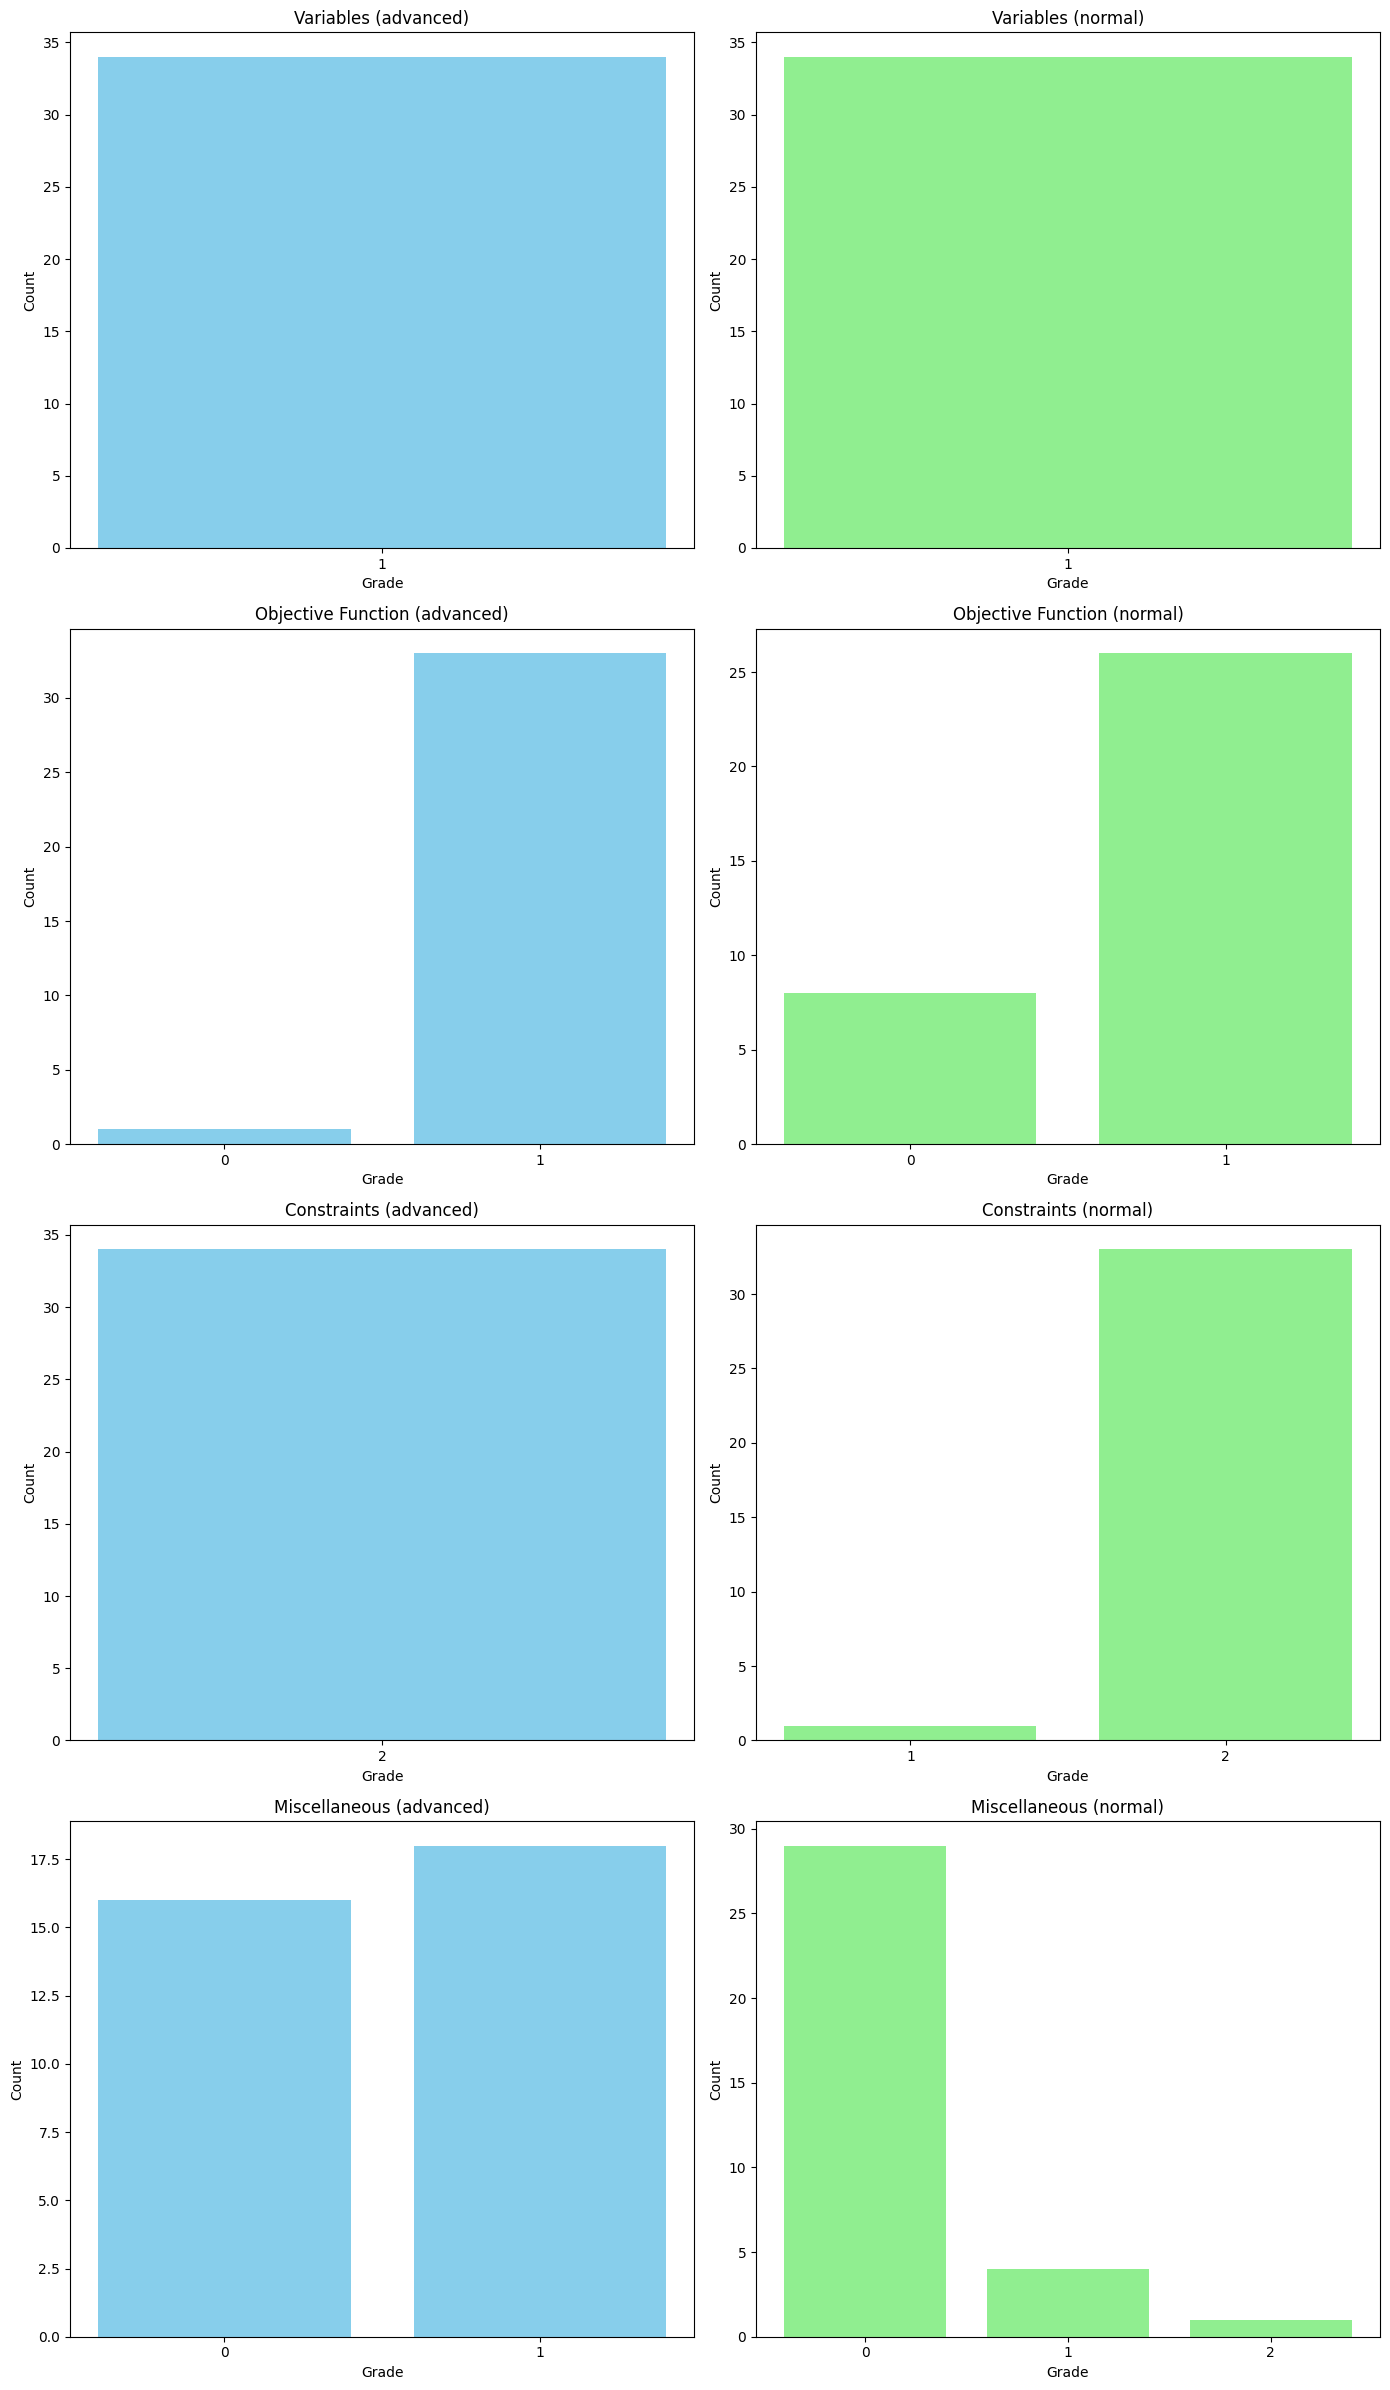

Category: Variables
Advanced Average Final Grade for Variables: 1.0
Advanced Grade Distribution for Variables:
parsed_scores
1    34
Name: count, dtype: int64
Normal Average Final Grade for Variables: 1.0
Normal Grade Distribution for Variables:
parsed_scores
1    34
Name: count, dtype: int64
Category: Objective Function
Advanced Average Final Grade for Objective Function: 0.9705882352941176
Advanced Grade Distribution for Objective Function:
parsed_scores
0     1
1    33
Name: count, dtype: int64
Normal Average Final Grade for Objective Function: 0.7647058823529411
Normal Grade Distribution for Objective Function:
parsed_scores
0     8
1    26
Name: count, dtype: int64
Category: Constraints
Advanced Average Final Grade for Constraints: 2.0
Advanced Grade Distribution for Constraints:
parsed_scores
2    34
Name: count, dtype: int64
Normal Average Final Grade for Constraints: 1.9705882352941178
Normal Grade Distribution for Constraints:
parsed_scores
1     1
2    33
Name: count, dtype: 

C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_advanced['parsed_scores'] = filtered_df_advanced['llm_score_advanced'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_normal['parsed_scores'] = filtered_df_normal['llm_score_normal'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py

In [120]:
validate_final_grade(df_manual, score=0, title="hardcoded")

C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_advanced['parsed_scores'] = filtered_df_advanced['llm_score_advanced'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_normal['parsed_scores'] = filtered_df_normal['llm_score_normal'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py

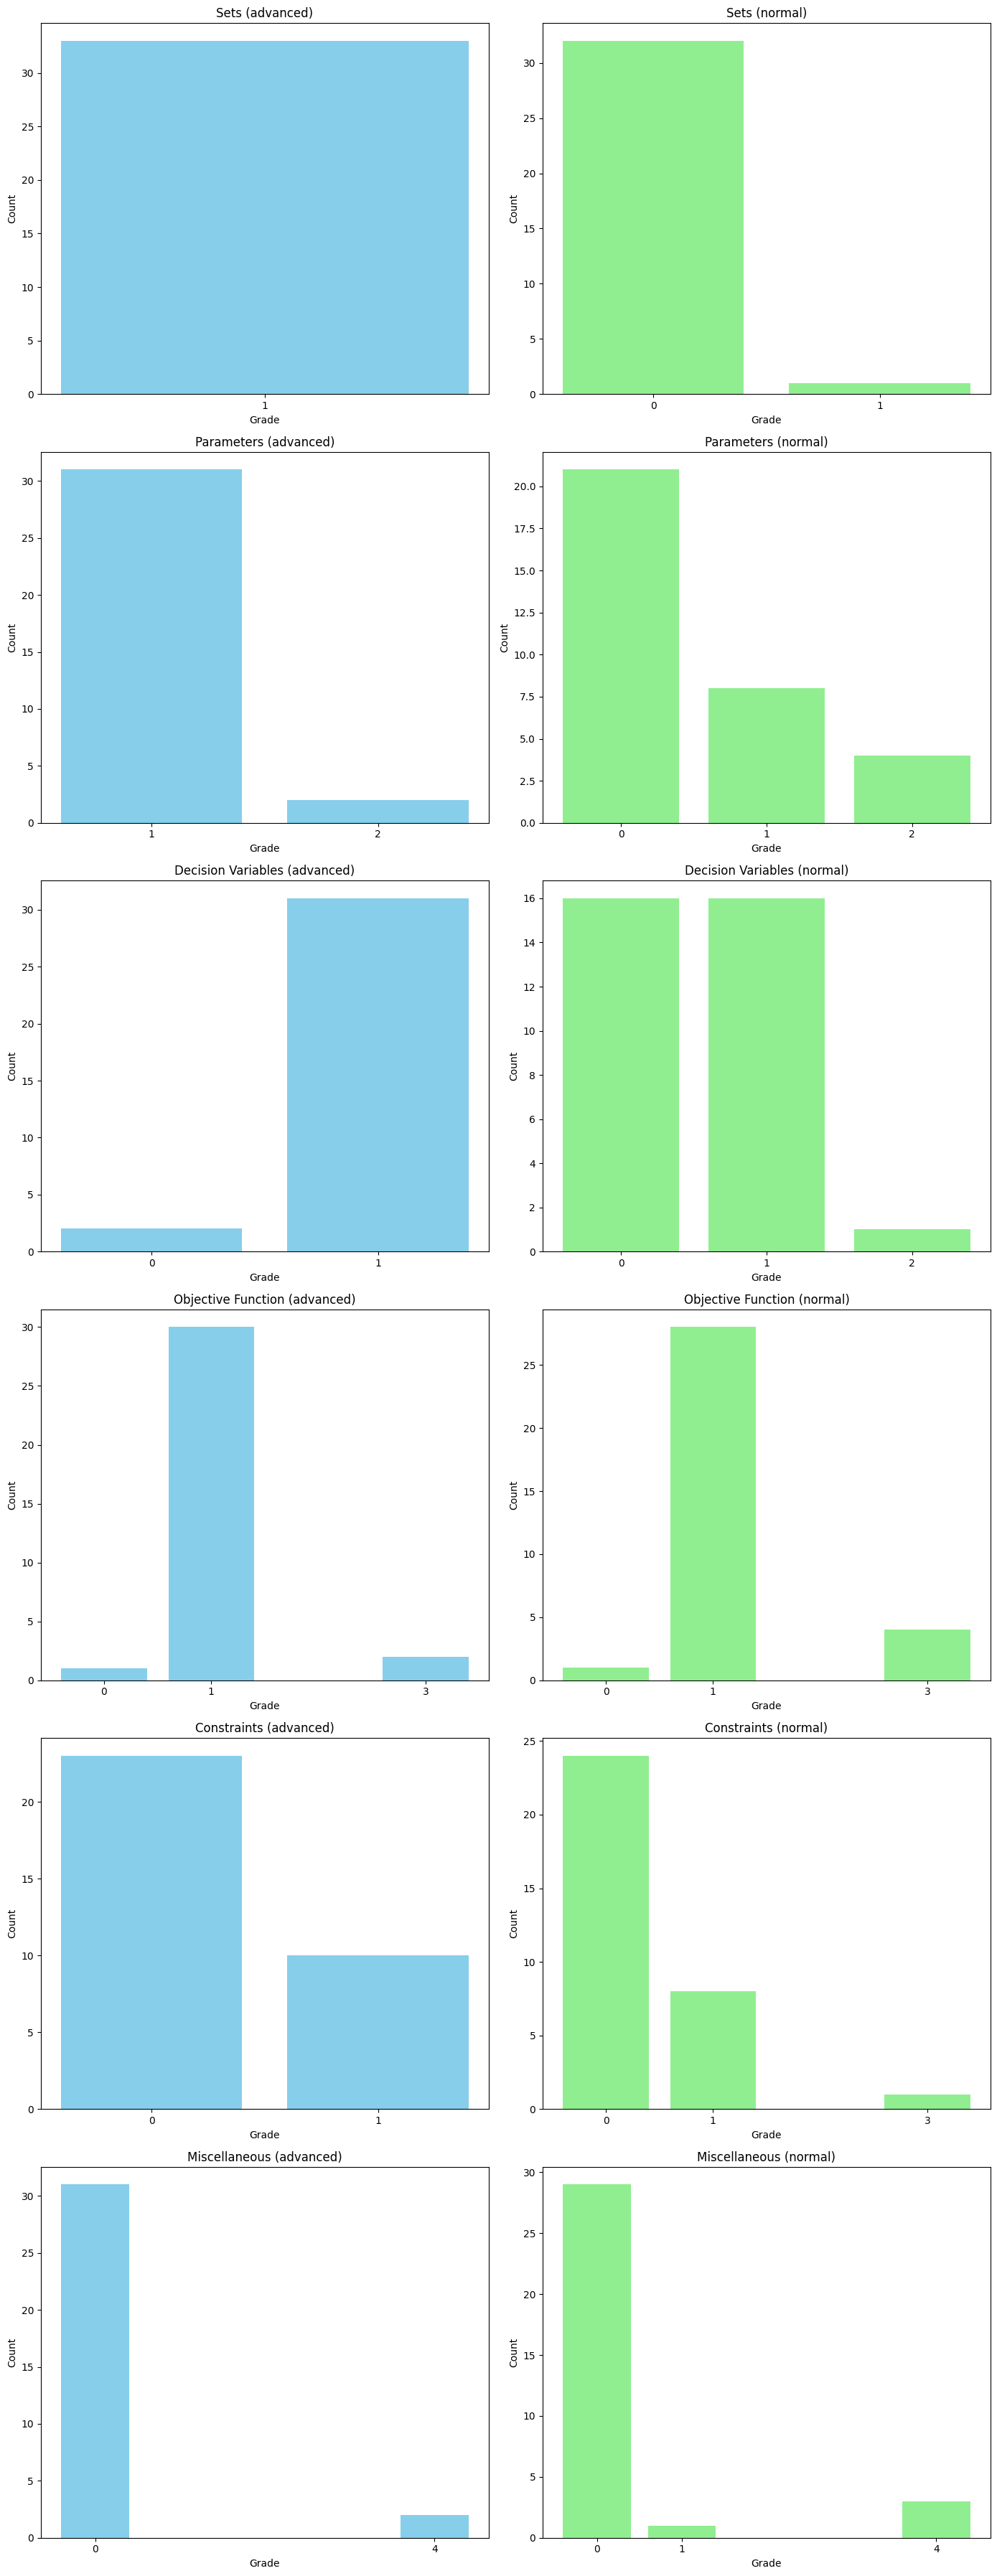

Category: Sets
Advanced Average Final Grade for Sets: 1.0
Advanced Grade Distribution for Sets:
parsed_scores
1    33
Name: count, dtype: int64
Normal Average Final Grade for Sets: 0.030303030303030304
Normal Grade Distribution for Sets:
parsed_scores
0    32
1     1
Name: count, dtype: int64
Category: Parameters
Advanced Average Final Grade for Parameters: 1.0606060606060606
Advanced Grade Distribution for Parameters:
parsed_scores
1    31
2     2
Name: count, dtype: int64
Normal Average Final Grade for Parameters: 0.48484848484848486
Normal Grade Distribution for Parameters:
parsed_scores
0    21
1     8
2     4
Name: count, dtype: int64
Category: Decision Variables
Advanced Average Final Grade for Decision Variables: 0.9393939393939394
Advanced Grade Distribution for Decision Variables:
parsed_scores
0     2
1    31
Name: count, dtype: int64
Normal Average Final Grade for Decision Variables: 0.5454545454545454
Normal Grade Distribution for Decision Variables:
parsed_scores
0    16
1

C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_advanced['parsed_scores'] = filtered_df_advanced['llm_score_advanced'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_normal['parsed_scores'] = filtered_df_normal['llm_score_normal'].apply(convert_response_to_list)
C:\Users\jagod\AppData\Local\Temp\ipykernel_3424\1879726833.py

In [121]:
validate_final_grade(df_manual, score=1, title="parameters")